# Visualized data

In [1279]:
%load_ext autoreload
%autoreload 2

import utils
import run
import evaluate

import numpy as np
import torch
import matplotlib.pyplot as plt

config = run.make_config('configs/horizonlstm_position.yaml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
using cpu


In [1280]:
torch_dict = torch.load('models/horizonlstm_position_lr0.001-l4-h200-mse_29-11-2023_21-02-50_e3600.p', map_location=torch.device('cpu'))

In [1281]:
config['model'].load_state_dict(torch_dict['model_state_dict'])

<All keys matched successfully>

In [1282]:
def plot_trajectories(y_pred, y, delta_p=True, ax=None):
    if delta_p:
        y_pred = np.vstack([[0, 0, 0], np.cumsum(y_pred, axis=0)])
        y = np.vstack([[0, 0, 0], np.cumsum(y, axis=0)])
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(y_pred[:, 0], y_pred[:, 1], "--", label="gt")
    ax.plot(y[:, 0], y[:, 1], "--", label="pred")

    ax.set_aspect('equal', adjustable='datalim')
    
    ax.legend()

def plot_compensated_error_vectors(y_pred, y, points=10, ax=None):
    if points is None:
        points = y_pred.shape[0]
    ce = utils.compensate_error(y_pred, y)
    y_pred = np.vstack([[0, 0, 0], np.cumsum(y_pred, axis=0)])
    y = np.vstack([[0, 0, 0], np.cumsum(y, axis=0)])
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(y_pred[:points, 0], y_pred[:points, 1], '-o', label='y_pred')  # last point has no comparison since it is from the last predicted output, so no other gt-point to go to
    ax.plot(y[:points + 1, 0], y[:points + 1, 1], '-o', label='y')
    for i in range(points):
        ep = y_pred[i] + ce[i]
        plt.plot([y_pred[i, 0], ep[0]], [y_pred[i, 1], ep[1]])
    ax.legend()

def get_car_frame_error(y_pred, y, r):
    rr = np.array([[np.cos(r), -np.sin(r)], [np.sin(r), np.cos(r)]]).transpose(2, 0, 1)
    sr = (y - y_pred)[:, :2]
    return np.einsum('BNi, Bi->BN', rr, sr)

16 9038
world frame error (max, mean): [2.1494587  0.57317749 0.02316989] [0.31794833 0.11826959 0.00463714]
car frame error (max, mean): [2.13177913 1.29032433] [0.27349992 0.18831318]


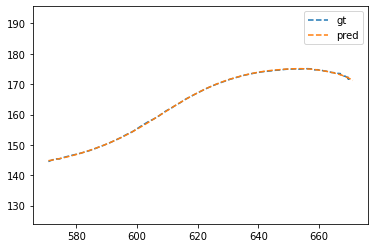

In [1345]:
i = np.random.randint(len(config['train_datasets']))
j = np.random.randint(len(config['train_datasets'][i]))

j = len(config['train_datasets'][i]) - 1

x, y = config['train_datasets'][i][j]

y *= config['train_datasets'][i].p_r
y_pred = config['model'](torch.tensor(x).float()).detach().numpy() * config['train_datasets'][i].p_r

print(i, j)
plot_trajectories(y_pred, y, delta_p=config['delta_p'])
#plot_trajectories(y , y, delta_p=config['delta_p'])

#ce = utils.compensate_error(y_pred, y)
#print(np.max(np.abs(ce), axis=0), np.mean(np.abs(ce), axis=0))
print('world frame error (max, mean):', np.max(np.abs(y_pred - y), axis=0), np.mean(np.abs(y_pred - y), axis=0))
cfe = get_car_frame_error(y_pred, y, x[:, -1])
print('car frame error (max, mean):', np.max(np.abs(cfe), axis=0), np.mean(np.abs(cfe), axis=0))